In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:

mnist.train.images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:

"""
definitions:
d
Training Parameter 

1. Learning Rate - The rate at which the Loss function gradient should descent
2. Epoch - One forward and one backward pass of ALL training examples
3. Batch size - The number of training examples to take in
    one forward and backward pass or one BATCH' of data.
4. Num of steps - lol no idea

Network Parameters

1. Input - The number of neurons in the first layer on in short the
    unwrapped (2D to 1D) of an image = 28*28= 784 here
2. Input classes - The number of classes the classification needs
    to made for
3. Dropout - For the model to NOT overfit the data, we tend to DROP some
of the neurons and run the passes. It is the fraction to drop 


"""
#training parameters
learning_rate=0.01
num_steps=2000
batch_size=128

#network params
num_input=784
num_classes=10
dropout=0.25



In [5]:

#create the skeleton of the neural net
def conv_net(x_dict,n_classes,dropout,reuse,is_training):
    #dont know of this step
    with tf.variable_scope('ConvNet',reuse=reuse):
        """
        this whole function is going to be used by a model_fn
        which in turn would be passed to the tf class tf.estimator.Estimator
        see more at 
        https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator
        """
        #the input is going to be a dictionary
        x=x_dict['images']
        #first layer is Conv so reshape back to 2D form and get conv layer
        #image=[batch size,height,width,channel]
        x=tf.reshape(x,shape=[-1,28,28,1])
        x = tf.identity(x, name='new_node')

        #first layer is a 2D conv layer with 32 filters with a size of 5
        #for a better understanding on what the number of filters mean: 
        #https://stackoverflow.com/questions/36243536/what-is-the-number-of-filter-in-cnn
        conv1=tf.layers.conv2d(x,32,5,activation=tf.nn.relu)
        #max pooling this 2D layer on down sampling(to get the max value only)
        #the pooling has 2 step size in the stride and 2 kernel size
        conv1=tf.layers.max_pooling2d(conv1,2,2)
        
        #same way we add another conv layer with 64 filters each of kernel 3
        conv2=tf.layers.conv2d(conv1,64,3,activation=tf.nn.relu)
        conv2=tf.layers.max_pooling2d(conv2,2,2)
        
        #flatten data now to get eventually get 10 classes of output
        fc1=tf.contrib.layers.flatten(conv2)
        
        #first connected layer consisting of 1024 neurons
        fc1=tf.layers.dense(fc1,1024)
        #apply dropout when training(is_training is the bool)
        fc1=tf.layers.dropout(fc1,rate=dropout,training=is_training)
        
        #finally output just 10 classes required with a connected layer
        out=tf.layers.dense(fc1,n_classes,name='final')
        out = tf.identity(out, name='last_node')
    return out        

In [6]:
#initialize a model function that is based on the template given at
#https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator

def model_fn(features,labels,mode):
    
    #building the NN, with two different graphs since the 
    #dropouts behave differently with training and predictions
    mod_train=conv_net(features,num_classes,dropout,reuse=False,is_training=True)
    mod_test=conv_net(features,num_classes,dropout,reuse=True,is_training=False)
    
    #softmax to convert prob between 0 to 1.
    pred_classes=tf.argmax(mod_test,axis=1)
    pred=tf.nn.softmax(mod_test)
    
     # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
    
    #loss and optimizer
    
    loss_fn=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=mod_train,labels=tf.cast(labels,dtype=tf.int32)))
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op=optimizer.minimize(loss_fn,global_step=tf.train.get_global_step())
    
    #get accuracy
    accuracy=tf.metrics.accuracy(labels=labels,predictions=pred_classes)
    
    #TF estimator has to return an EstimatorSpec object (same in the case if
    #mode =PREDICT)
    
    estimation_ret=tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_fn,
        train_op=train_op,
        eval_metric_ops={'accuracy':accuracy})
    
    return estimation_ret

In [7]:
model=tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0faf318950>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpTHmh4s', '_train_distribute': None, '_save_summary_steps': 100}


In [8]:
input_fn=tf.estimator.inputs.numpy_input_fn(x={'images': mnist.train.images},y=mnist.train.labels,
                                           batch_size=batch_size,num_epochs=None,shuffle=True)
#start training the model
model.train(input_fn,steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpTHmh4s/model.ckpt.
INFO:tensorflow:loss = 2.306107, step = 0
INFO:tensorflow:global_step/sec: 207.38
INFO:tensorflow:loss = 0.23269051, step = 100 (0.485 sec)
INFO:tensorflow:global_step/sec: 204.107
INFO:tensorflow:loss = 0.14222658, step = 200 (0.490 sec)
INFO:tensorflow:global_step/sec: 205.925
INFO:tensorflow:loss = 0.09132413, step = 300 (0.486 sec)
INFO:tensorflow:global_step/sec: 224.633
INFO:tensorflow:loss = 0.17017175, step = 400 (0.445 sec)
INFO:tensorflow:global_step/sec: 232.92
INFO:tensorflow:loss = 0.062012345, step = 500 (0.429 sec)
INFO:tensorflow:global_step/sec: 214.249
INFO:tensorflow:loss = 0.21434395, step = 600 (0.468 sec)
INFO:tensorflow:global_step/sec: 216.27
INFO:tensorflow

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpTHmh4s/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


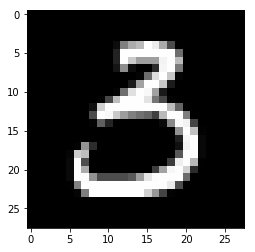

3


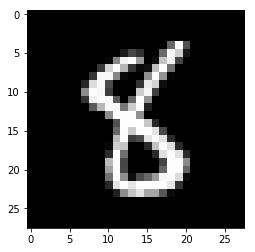

8


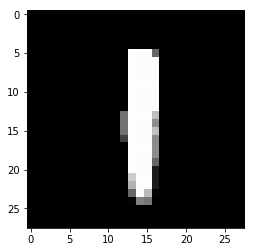

1


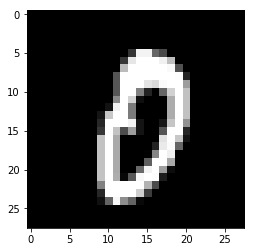

0


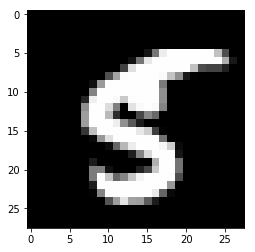

5


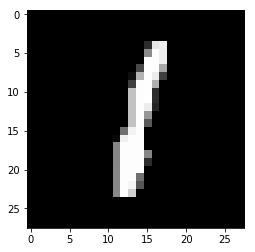

1


In [9]:
#prediction
test_images=mnist.test.images[343:353]

input_fn=tf.estimator.inputs.numpy_input_fn(
    x={'images':test_images},shuffle=False)

predictions=list(model.predict(input_fn))

for i in range(6):
    plt.imshow(np.reshape(test_images[i],[28,28]),cmap='gray')
    plt.show()
    print(predictions[i])

In [12]:
with open("model.json", "w") as file:
    file.write(model.model.to_json())
model.save_weights("weights.h5")
model.save('model.h5')


AttributeError: 'Estimator' object has no attribute 'model'